In [ ]:
from pyspark.sql import SparkSession
import plotly.express as px
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.sql.functions import when,col,isnan
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
import pickle

In [10]:
spark = SparkSession.builder \
            .appName("Breast Cancer Classification") \
            .master("local[*]") \
            .getOrCreate()

25/03/21 22:47:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Load Dataset

In [11]:
df = spark.read.csv("file:///root/myproject/Data/data.csv",header=True,inferSchema=True)

### Show Schema

In [12]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radi

### Show 5 rows

In [13]:
df.show(5)

25/03/21 22:47:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, 
 Schema: id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_wor

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

In [14]:
df = df.withColumn("diagnosis",when(df['diagnosis'] == 'M',1).otherwise(0))
df = df.drop("Unnamed: 32","id","_c32")
df = df.withColumnRenamed("concave points_mean","concave_points_mean")
df = df.withColumnRenamed("concave points_se","concave_points_se")
df = df.withColumnRenamed("concave points_worst","concave_points_worst")

In [15]:
df.show(4)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [ ]:

numerical_columns = df.columns
numerical_columns

['diagnosis',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

## Check Nan Values

In [ ]:
# Check for missing values
def check_missing_values(df):
    missing_counts = []
    for col_name in df.columns:
        col_type = dict(df.dtypes)[col_name]
        if col_type in ["double", "float"]:
            missing_count = df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
        
        else:
            missing_count = df.filter(col(col_name).isNull()).count()
       
        missing_counts.append((col_name, missing_count, (missing_count / df.count()) * 100))
    
    missing_df = pd.DataFrame(missing_counts, columns=['Column', 'Missing Count', 'Missing Percentage'])
    return missing_df.sort_values('Missing Percentage', ascending=False)

missing_values_df = check_missing_values(df)
print("\nMissing Values Analysis:")
print(missing_values_df)


Missing Values Analysis:
                     Column  Missing Count  Missing Percentage
0                 diagnosis              0                 0.0
1               radius_mean              0                 0.0
2              texture_mean              0                 0.0
3            perimeter_mean              0                 0.0
4                 area_mean              0                 0.0
5           smoothness_mean              0                 0.0
6          compactness_mean              0                 0.0
7            concavity_mean              0                 0.0
8       concave_points_mean              0                 0.0
9             symmetry_mean              0                 0.0
10   fractal_dimension_mean              0                 0.0
11                radius_se              0                 0.0
12               texture_se              0                 0.0
13             perimeter_se              0                 0.0
14                  area_se  

## Scale values

In [ ]:
assembler = VectorAssembler(inputCols=numerical_columns,outputCol="features")
df = assembler.transform(df)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


In [ ]:
df.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+--------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|            features|    

In [ ]:
df1 = df.select("diagnosis","scaled_features")
df1.show(5)

+---------+--------------------+
|diagnosis|     scaled_features|
+---------+--------------------+
|        0|[0.0,5.1049235941...|
|        0|[0.0,5.8370360384...|
|        0|[0.0,5.5873232667...|
|        0|[0.0,3.2405907418...|
|        0|[0.0,5.7575819747...|
+---------+--------------------+
only showing top 5 rows



### Split Data

In [ ]:
train_df, test_df = df1.randomSplit([0.8,0.2], seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="scaled_features",labelCol='diagnosis',maxIter=10)
model = lr.fit(train_df)

25/03/17 23:51:36 WARN Instrumentation: [6ec87699] All labels are the same value and fitIntercept=true, so the coefficients will be zeros. Training is not needed.


In [ ]:
predictions = model.transform(test_df)


In [ ]:
predictions.select("diagnosis","prediction","probability").show(10)

+---------+----------+-----------+
|diagnosis|prediction|probability|
+---------+----------+-----------+
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
+---------+----------+-----------+
only showing top 10 rows



### Evaluator

In [ ]:
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

print(accuracy)


1.0


In [ ]:
# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(precision)

1.0


In [ ]:
# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(recall)

1.0


In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Breast Cancer Classification") \
    .master("local[*]") \
    .getOrCreate()

# Load the breast cancer dataset
df = spark.read.csv("file:///root/myproject/Data/data.csv", header=True, inferSchema=True)

# Step 1: Inspect the Data
print("Data Overview:")
df.show(5)
df.printSchema()

# Step 2: Encode the target variable
# Assuming 'diagnosis' column has 'M' for malignant and 'B' for benign
df = df.withColumn("diagnosis",when(df['diagnosis'] == 'M',1).otherwise(0))
df = df.drop("Unnamed: 32","id","_c32")
df = df.withColumnRenamed("concave points_mean","concave_points_mean")
df = df.withColumnRenamed("concave points_se","concave_points_se")
df = df.withColumnRenamed("concave points_worst","concave_points_worst")

# Step 3: Drop the original diagnosis column
df = df.drop("Unnamed: 32","id","_c32")

# Step 4: Select numerical features (you may need to adjust this based on your dataset)
numerical_features = [col for col in df.columns if col != "diagnosis"]# This includes 'label'

# Step 5: Assemble features into a single vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df = assembler.transform(df)

# Step 6: Scale features
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Step 7: Keep only the scaled features and the label
df = df.select("diagnosis", "scaled_features")

# Step 8: Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train the Logistic Regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="diagnosis", maxIter=10)
model = lr.fit(train_df)

# Step 10: Make predictions on the test set
predictions = model.transform(test_df)

# Step 11: Evaluate the model
# Fix for BinaryClassificationEvaluator
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="diagnosis", 
    rawPredictionCol="rawPrediction",  # Use raw scores, not the final prediction
    metricName="areaUnderROC"
)

roc_auc = evaluator_roc.evaluate(predictions)

# Additional metrics for evaluation
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="diagnosis", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# Print the evaluation metrics
print(f"Area Under ROC: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Show predictions
predictions.select("diagnosis", "prediction", "probability").show(20)

# Stop the Spark session
#spark.stop()

Data Overview:


25/03/21 22:48:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, 
 Schema: id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_wor

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

25/03/21 22:48:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Area Under ROC: 0.99
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
+---------+----------+--------------------+
|diagnosis|prediction|         probability|
+---------+----------+--------------------+
|        0|       0.0|[0.99999990767926...|
|        0|       0.0|[0.99999988871828...|
|        0|       0.0|[0.99999708433982...|
|        0|       0.0|[0.99999997427032...|
|        0|       0.0|[0.99999999965709...|
|        0|       0.0|[0.99999999380780...|
|        0|       0.0|[0.99999910608101...|
|        0|       0.0|[0.99999999999071...|
|        0|       0.0|[0.99997663777348...|
|        0|       0.0|[0.99999999846509...|
|        0|       0.0|[0.99999995875697...|
|        0|       0.0|[0.99999269048069...|
|        0|       0.0|[0.99999999724930...|
|        0|       0.0|[0.99999999075562...|
|        0|       0.0|[0.98499580654726...|
|        0|       0.0|[0.99998841900099...|
|        0|       0.0|[0.99999997834239...|
|        0|       0.0|[0.99999987969877...|
|        0|

+---------+--------------------+
|diagnosis|     scaled_features|
+---------+--------------------+
|        1|[0.52103743669837...|
+---------+--------------------+
only showing top 1 row



In [ ]:
df_predictions = predictions.toPandas()
df_predictions

,diagnosis,scaled_features,rawPrediction,probability,prediction
0,0,"[0.03540158076577218, 0.5336489685492052, 0.02...","[16.197997020259766, -16.197997020259766]","[0.9999999076792686, 9.23207313929808e-08]",0.0
1,0,"[0.07525202328553174, 0.11464321947920185, 0.0...","[16.011200757984522, -16.011200757984522]","[0.9999998887182842, 1.1128171584218194e-07]",0.0
2,0,"[0.07652988783188987, 0.38112952316537024, 0.0...","[12.745411373178055, -12.745411373178055]","[0.9999970843398255, 2.9156601745183863e-06]",0.0
3,0,"[0.0897818164607885, 0.19546838011498135, 0.08...","[17.475620646237267, -17.475620646237267]","[0.9999999742703207, 2.5729679276054185e-08]",0.0
4,0,"[0.1037436698376639, 0.14034494420020285, 0.10...","[21.793565845570097, -21.793565845570097]","[0.9999999996570943, 3.429057038317751e-10]",0.0
...,...,...,...,...,...
81,1,"[0.6014955748024043, 0.3902603990530943, 0.595...","[-26.51437497857117, 26.51437497857117]","[3.0545923213565262e-12, 0.9999999999969454]",1.0
82,1,"[0.6388849448625114, 0.397362191410213, 0.6130...","[-17.59178455760737, 17.59178455760737]","[2.2907886878274066e-08, 0.9999999770921131]",1.0
83,1,"[0.6682285011122155, 0.36557321609739596, 0.65...","[-28.730856231799578, 28.730856231799578]","[3.3292597338175813e-13, 0.999999999999667]",1.0
84,1,"[0.6989919068578732, 0.38146770375380445, 0.71...","[-37.10174795455664, 37.10174795455664]","[7.707536576521048e-17, 0.9999999999999999]",1.0


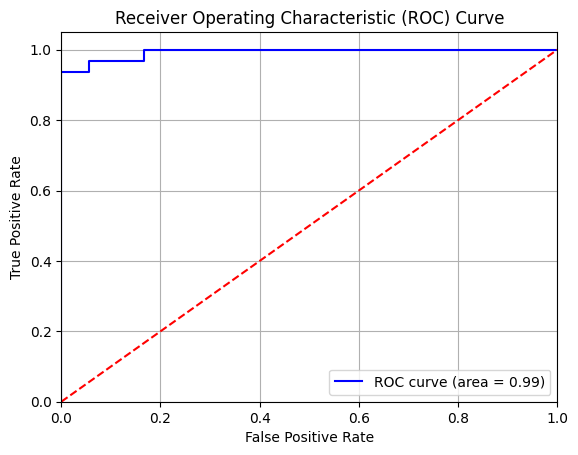

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 12: Extract true labels and predicted probabilities
y_true = predictions.select("diagnosis").rdd.flatMap(lambda x: x).collect()
y_scores = predictions.select("probability").rdd.flatMap(lambda x: x).collect()
y_scores = [float(prob[1]) for prob in y_scores]  # Get the probability of the positive class

# Step 13: Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc_value = auc(fpr, tpr)

# Step 14: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from pyspark.sql import Row

# Clean column names in training data first (add this to your training code)
# df = df.toDF(*[col.replace(' ', '_') for col in df.columns])

# Example new data with corrected column names (using underscores)
new_examples = [
    Row(
        radius_mean=14.0, 
        texture_mean=20.0, 
        perimeter_mean=85.0, 
        area_mean=550.0,
        smoothness_mean=0.1, 
        compactness_mean=0.15, 
        concavity_mean=0.2, 
        concave_points_mean=0.1,  # Corrected: underscore instead of space
        symmetry_mean=0.25, 
        fractal_dimension_mean=0.07,
        radius_se=0.3, 
        texture_se=1.0, 
        perimeter_se=2.1, 
        area_se=30.0, 
        smoothness_se=0.03, 
        compactness_se=0.06, 
        concavity_se=0.04, 
        concave_points_se=0.03,  # Corrected
        symmetry_se=0.02, 
        fractal_dimension_se=0.01,
        radius_worst=16.0, 
        texture_worst=26.0, 
        perimeter_worst=97.0, 
        area_worst=650.0, 
        smoothness_worst=0.12, 
        compactness_worst=0.18, 
        concavity_worst=0.25, 
        concave_points_worst=0.15,  # Corrected
        symmetry_worst=0.3, 
        fractal_dimension_worst=0.09
    )
]

# Create DataFrame with cleaned column names
new_examples_df = spark.createDataFrame(new_examples)

# Verify column names match training data
print("Example Data Schema:")
new_examples_df.printSchema()

# Reuse the same feature pipeline as training
assembled_examples = assembler.transform(new_examples_df)
scaled_examples = scaler_model.transform(assembled_examples)

# Make predictions
predictions = model.transform(scaled_examples)

# Show results
predictions.select("probability", "prediction").show(truncate=False)


Example Data Schema:
root
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave_points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)
 |-- texture_worst: 

In [ ]:
# Example new data (different values)
new_examples = [
    Row(
        radius_mean=18.0, 
        texture_mean=22.0, 
        perimeter_mean=100.0, 
        area_mean=700.0,
        smoothness_mean=0.12, 
        compactness_mean=0.18, 
        concavity_mean=0.25, 
        concave_points_mean=0.15,  
        symmetry_mean=0.3, 
        fractal_dimension_mean=0.08,
        radius_se=0.4, 
        texture_se=1.2, 
        perimeter_se=2.5, 
        area_se=40.0, 
        smoothness_se=0.04, 
        compactness_se=0.08, 
        concavity_se=0.06, 
        concave_points_se=0.05,  
        symmetry_se=0.03, 
        fractal_dimension_se=0.02,
        radius_worst=20.0, 
        texture_worst=30.0, 
        perimeter_worst=120.0, 
        area_worst=900.0, 
        smoothness_worst=0.15, 
        compactness_worst=0.22, 
        concavity_worst=0.30, 
        concave_points_worst=0.20,  
        symmetry_worst=0.35, 
        fractal_dimension_worst=0.10
    )
]

# Create DataFrame
new_examples_df = spark.createDataFrame(new_examples)

# Verify schema
new_examples_df.printSchema()

# Assemble and scale features
assembled_examples = assembler.transform(new_examples_df)
scaled_examples = scaler_model.transform(assembled_examples)

# Predict
predictions = model.transform(scaled_examples)
predictions.select("probability", "prediction").show(truncate=False)


root
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave_points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)
 |-- texture_worst: double (nullable = tr

### Another test of prediction

In [ ]:

# Create a list of dictionaries representing the test example
example_data2 = [
    {
        "radius_mean": 12.5, 
        "texture_mean": 18.3, 
        "perimeter_mean": 78.2, 
        "area_mean": 450.0,
        "smoothness_mean": 0.08, 
        "compactness_mean": 0.12, 
        "concavity_mean": 0.10, 
        "concave_points_mean": 0.07,
        "symmetry_mean": 0.18, 
        "fractal_dimension_mean": 0.06,
        "radius_se": 0.25, 
        "texture_se": 0.80, 
        "perimeter_se": 1.5, 
        "area_se": 15.0, 
        "smoothness_se": 0.02, 
        "compactness_se": 0.04, 
        "concavity_se": 0.03, 
        "concave_points_se": 0.02,
        "symmetry_se": 0.01, 
        "fractal_dimension_se": 0.007,
        "radius_worst": 14.0, 
        "texture_worst": 23.0, 
        "perimeter_worst": 90.0, 
        "area_worst": 600.0, 
        "smoothness_worst": 0.10, 
        "compactness_worst": 0.14, 
        "concavity_worst": 0.15, 
        "concave_points_worst": 0.09,
        "symmetry_worst": 0.22, 
        "fractal_dimension_worst": 0.08
    }
]

example2_df = spark.createDataFrame(example_data2)
example2_df.show(1)

+---------+-------+----------+----------------+--------------+-----------------+-------------------+-----------------+--------------------+--------------+------------+---------------+----------------------+--------------------+-----------------------+--------------+------------+---------------+-----------+---------+------------+---------------+-------------+----------------+-------------+-----------+--------------+------------+----------+-------------+
|area_mean|area_se|area_worst|compactness_mean|compactness_se|compactness_worst|concave_points_mean|concave_points_se|concave_points_worst|concavity_mean|concavity_se|concavity_worst|fractal_dimension_mean|fractal_dimension_se|fractal_dimension_worst|perimeter_mean|perimeter_se|perimeter_worst|radius_mean|radius_se|radius_worst|smoothness_mean|smoothness_se|smoothness_worst|symmetry_mean|symmetry_se|symmetry_worst|texture_mean|texture_se|texture_worst|
+---------+-------+----------+----------------+--------------+-----------------+------

In [ ]:
assembled2 = assembler.transform(example2_df)
scaled_examples2 = scaler_model.transform(assembled2)
predictions2 = model.transform(scaled_examples2)
predictions2.select("probability","prediction").show(truncate=False)

+------------------------------------------+----------+
|probability                               |prediction|
+------------------------------------------+----------+
|[0.9999870006564905,1.2999343509512151E-5]|0.0       |
+------------------------------------------+----------+



In [ ]:
model.save(path="file:///root/myproject/LR")

In [ ]:
scaler_model.save("file:///root/myproject/Scaler")

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
loaded = LogisticRegressionModel.load("file:///root/myproject/LR")
loaded

25/03/19 23:13:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("test").master("local[*]").getOrCreate()
from pyspark.ml.classification import LogisticRegressionModel
model = LogisticRegressionModel.load("file:///root/myproject/Model/LR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [22]:

# Create a list of dictionaries representing the test example
example_data3 = [
   {"radius_mean": 20.762, "texture_mean": 30.8226, "perimeter_mean": 133.5422, "area_mean": 424.255, "smoothness_mean": 0.0458, "compactness_mean": 0.3431, "concavity_mean": 0.2627, "concave_points_mean": 0.1902, "symmetry_mean": 0.0182, "fractal_dimension_mean": 0.0712, "radius_se": 1.5064, "texture_se": 3.1626, "perimeter_se": 2.9189, "area_se": 79.0923, "smoothness_se": 0.0121, "compactness_se": 0.0096, "concavity_se": 0.1574, "concave_points_se": 0.0323, "symmetry_se": 0.0008, "fractal_dimension_se": 0.0207, "radius_worst": 5.8652, "texture_worst": 39.0638, "perimeter_worst": 100.1484, "area_worst": 1769.8053, "smoothness_worst": 0.0915, "compactness_worst": 0.431, "concavity_worst": 0.2117, "concave_points_worst": 0.2887, "symmetry_worst": 0.4034, "fractal_dimension_worst": 0.0245}
]

example3_df = spark.createDataFrame(example_data2)
example3_df.show(1)

+---------+--------+----------+----------------+--------------+-----------------+-------------------+-----------------+--------------------+--------------+------------+---------------+----------------------+--------------------+-----------------------+--------------+------------+---------------+-----------+---------+------------+---------------+-------------+----------------+-------------+-----------+--------------+------------+----------+-------------+
|area_mean| area_se|area_worst|compactness_mean|compactness_se|compactness_worst|concave_points_mean|concave_points_se|concave_points_worst|concavity_mean|concavity_se|concavity_worst|fractal_dimension_mean|fractal_dimension_se|fractal_dimension_worst|perimeter_mean|perimeter_se|perimeter_worst|radius_mean|radius_se|radius_worst|smoothness_mean|smoothness_se|smoothness_worst|symmetry_mean|symmetry_se|symmetry_worst|texture_mean|texture_se|texture_worst|
+---------+--------+----------+----------------+--------------+-----------------+---

In [23]:
from pyspark.ml.feature import MinMaxScalerModel,VectorAssembler
assembler3 = VectorAssembler(inputCols=numerical_features, outputCol="features")
scaler_model3 = MinMaxScalerModel.load("file:///root/myproject/Model/Scaler")
df3 = assembler3.transform(example3_df)
scaled_examples3 = scaler_model3.transform(df3)
predictions3 = model.transform(scaled_examples3)
predictions3.select("probability","prediction").show(truncate=False)

# assembled2 = assembler.transform(example2_df)
# scaled_examples2 = scaler_model.transform(assembled2)
# predictions2 = model.transform(scaled_examples2)
# predictions2.select("probability","prediction").show(truncate=False)

+-------------------------------------------+----------+
|probability                                |prediction|
+-------------------------------------------+----------+
|[3.9216654843137864E-16,0.9999999999999996]|1.0       |
+-------------------------------------------+----------+

